In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
import tensorflow_hub as hub
import time
import pandas as pd


from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

In [ ]:
data_dir = 'C:\\Users\\ardo\\Documents\\semai\\dataset\\ripeness\\ripeness_v8.0'
print(data_dir)

In [ ]:
IMAGE_SIZE = 224
BATCH_SIZE = 32

datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255, 
    validation_split=0.2)

train_generator = datagen.flow_from_directory(
    data_dir,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE, 
    subset='training')

val_generator = datagen.flow_from_directory(
    data_dir,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE, 
    subset='validation')

for image_batch, label_batch in train_generator:
  break
image_batch.shape, label_batch.shape

In [ ]:
print (train_generator.class_indices)

labels = '\n'.join(sorted(train_generator.class_indices.keys()))

with open('labels_ripe.txt', 'w') as f:
  f.write(labels)

In [ ]:
IMG_SHAPE = (IMAGE_SIZE, IMAGE_SIZE, 3)

# Create the base model from the pre-trained model MobileNet V2
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                              include_top=False, 
                                              weights='imagenet')

In [ ]:
base_model.trainable = False

model = tf.keras.Sequential([
  base_model,
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.GlobalAveragePooling2D(),
  tf.keras.layers.Dense(4, activation='softmax')
])

model.compile(optimizer=tf.keras.optimizers.Adam(), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

model.summary()

print('Number of trainable variables = {}'.format(len(model.trainable_variables)))

In [ ]:
epochs = 10

history = model.fit(train_generator, 
                    steps_per_epoch=len(train_generator), 
                    epochs=epochs, 
                    validation_data=val_generator, 
                    validation_steps=len(val_generator))

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
base_model.trainable = True

# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

model.compile(loss='categorical_crossentropy',
              optimizer = tf.keras.optimizers.Adam(1e-5),
              metrics=['accuracy'])

model.summary()

print('Number of trainable variables = {}'.format(len(model.trainable_variables)))

In [ ]:
epochs = 5

history_fine = model.fit(train_generator, 
                         steps_per_epoch=len(train_generator), 
                         epochs=epochs, 
                         validation_data=val_generator, 
                         validation_steps=len(val_generator))

In [ ]:
acc = history_fine.history['accuracy']
val_acc = history_fine.history['val_accuracy']

loss = history_fine.history['loss']
val_loss = history_fine.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
saved_model_dir = 'save/fine_tuning'
tf.saved_model.save(model, saved_model_dir)

converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_dir)
tflite_model = converter.convert()

with open('model.tflite', 'wb') as f:
  f.write(tflite_model)

In [ ]:
batch_size = 32
img_height = 224
img_width = 224

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=135,
  image_size=(img_height, img_width),
  batch_size=batch_size,
  shuffle=True
)

In [ ]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=135,
  image_size=(img_height, img_width),
  batch_size=batch_size,
  shuffle=True
)

In [ ]:
class_names = train_ds.class_names
print(class_names)

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)

In [ ]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

In [ ]:
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(img_height, 
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

In [ ]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [ ]:
num_classes = 4

model = Sequential([
  data_augmentation,
  normalization_layer,
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.3),
  layers.Flatten(),
  layers.Dense(256, activation='relu'),
  layers.Dropout(0.6),
  layers.Dense(num_classes, activation='relu'),
  layers.Dense(num_classes, activation='softmax')
])

model.summary()

In [ ]:
early_stop_cuy = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=0, patience=100, verbose=0,
    mode='auto', baseline=None, restore_best_weights=True
)

model.compile(
    optimizer=tf.keras.optimizers.Adam(
        lr=0.0005
    ),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'])

epochs = 1000
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  callbacks=[early_stop_cuy]
)

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(255)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
tandan_url = "https://akacn.ac.id/wp-content/uploads/2020/11/tandon-kosong-1.png"
tandan_loc = "C:\\Users\\ardo\\Documents\\personal\\dev\\notebook\\test_ripe_0604\\tandan_kos.jpg"
tandan_path = tf.keras.utils.get_file(tandan_loc, origin=tandan_url)

test_img = "C:\\Users\\ardo\\Documents\\semai\\dataset\\ripeness\\ripeness_v8.0\\lewat matang\\download--2-_jpg.rf.0a6fe1263e7000eaa81c5b8b6c3a8a90.jpg"

img = keras.preprocessing.image.load_img(
    test_img, target_size=(img_height, img_width)
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(predictions)
print(class_names)
print(np.round(score, 3))

print(
    "This image most likely belongs to {} with a {:.1f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

plt.imshow(img)

In [ ]:
#if error, delete folder cache from latest downloaded
mobilenet_url = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"
feature_extractor = hub.KerasLayer(mobilenet_url,
                                   input_shape=(img_height, img_width, 3))

feature_extractor.trainable = False

In [ ]:
num_classes = 4

model = Sequential([
    data_augmentation,
    #normalization_layer,
    feature_extractor,
    #layers.Dense(256, activation='relu'),
    #layers.Dropout(0.7),
    #layers.Dense(128, activation='relu'),
    layers.Dropout(0.7),
    layers.Dense(num_classes, activation='softmax')
    #layers.Dense(num_classes)
    #layers.ReLU(max_value=1.0)
])

model.summary()

In [ ]:
early_stop_cuy = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=0, patience=50, verbose=0,
    mode='auto', baseline=None, restore_best_weights=True
)

model.compile(
  optimizer=tf.keras.optimizers.Adam(
        lr=0.004
  ),
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

epochs = 1000
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  callbacks=[early_stop_cuy]
)

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

# change as epoch stopped
epochs_range = range(131)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
tandan_url = "https://docplayer.info/docs-images/70/62137124/images/31-0.jpg"
tandan_loc = "C:\\Users\\ardo\\Documents\\personal\\dev\\notebook\\test_ripe_0604\\tandan_lewat.jpg"
tandan_path = tf.keras.utils.get_file(tandan_loc, origin=tandan_url)

test_img = "C:\\Users\\ardo\\Documents\\semai\\dataset\\ripeness\\ripeness_v7.1\\belum matang\\4_jpg.rf.6da018ee5194f730fa76294e2ea00131.jpg"

img = keras.preprocessing.image.load_img(
    tandan_path, target_size=(img_height, img_width)
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(predictions)
print(class_names)
print(np.round(score, 3))

print(
    "This image most likely belongs to {} with a {:.1f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

plt.imshow(img)

In [85]:
timename = time.strftime("%Y%m%d%H%M%S")
saved_model_path = "ripeness-" + timename + ".h5" # or you can simply use 'my_model.h5'
model.save(saved_model_path) #save your model

In [86]:
# to reload your model if no snippet keras layer e.g MobileNetV2
model = keras.models.load_model(saved_model_path)

#model = keras.models.load_model(saved_model_path, custom_objects={'KerasLayer':hub.KerasLayer})
#model = keras.models.load_model('ripeness-20210409151225.h5', custom_objects={'KerasLayer':hub.KerasLayer})
model.summary()

Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 5, 5, 32)          368672    
_________________________________________________________________
dropout_21 (Dropout)         (None, 5, 5, 32)          0         
_________________________________________________________________
global_average_pooling2d_1 ( (None, 32)                0         
_________________________________________________________________
dense_30 (Dense)             (None, 4)                 132       
Total params: 2,626,788
Trainable params: 2,231,396
Non-trainable params: 395,392
_________________________________________________________________


In [87]:
model.evaluate(val_generator, batch_size=32)

4/4 [==============================] - 0s 37ms/step - loss: 0.4647 - accuracy: 0.8120


[0.46468085050582886, 0.811965823173523]

In [ ]:
model.evaluate(val_ds, batch_size=32)

In [94]:
# Get images and labels batch from validation dataset generator
val_image_batch, val_label_batch = next(iter(val_generator))
print("Validation batch shape:", val_image_batch.shape)

# Get predictions for images batch
tf_model_predictions = model.predict(val_image_batch)

score = np.round(tf_model_predictions, 4)
# >> Prediction results shape: (32, 5)

# Convert prediction results to Pandas dataframe, for better visualization
tf_pred_dataframe_ori = pd.DataFrame(score)
tf_pred_dataframe_ori.columns = class_names

tf_pred_dataframe_ori.head()


Validation batch shape: (32, 224, 224, 3)


,belum matang,jankos,lewat matang,matang
0,0.0000,0.0,0.0002,0.9998
1,0.9925,0.0,0.0074,0.0001
2,0.9792,0.0,0.0203,0.0005
3,0.0187,0.0,0.9394,0.0419
4,0.0000,0.0,0.2176,0.7824


In [ ]:
# Get images and labels batch from validation dataset generator
val_image_batch, val_label_batch = next(iter(val_ds))
print("Validation batch shape:", val_image_batch.shape)

# Get predictions for images batch
tf_model_predictions = model.predict(val_image_batch)
score = tf.nn.softmax(tf_model_predictions)
print("Prediction results shape:", score.shape)
score = np.round(score, 4)
# >> Prediction results shape: (32, 5)

# Convert prediction results to Pandas dataframe, for better visualization
tf_pred_dataframe = pd.DataFrame(score)
tf_pred_dataframe.columns = class_names

tf_pred_dataframe.head()


In [ ]:
tf_pred_dataframe_ori = pd.DataFrame(tf_model_predictions)
tf_pred_dataframe_ori.columns = class_names

tf_pred_dataframe_ori.head()

['lewat matang' 'matang' 'matang' 'belum matang' 'belum matang'
 'belum matang' 'lewat matang' 'matang' 'belum matang' 'belum matang'
 'lewat matang' 'belum matang' 'belum matang' 'lewat matang' 'matang'
 'matang' 'matang' 'belum matang' 'matang' 'matang' 'matang'
 'belum matang' 'lewat matang' 'matang' 'matang' 'matang' 'belum matang'
 'belum matang' 'matang' 'lewat matang' 'matang' 'matang']
Labels:            [[0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]]
Predicted labels:  [2 3 3 0 0 0 2 3 0 0 2 0 0 2 3 3 3 0 3 3 3 0 2 3 3 3 0 0 3 2 3 3]


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

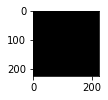

In [92]:
image_batch = val_image_batch.numpy()
label_batch = val_label_batch.numpy()

predicted_batch = model.predict(image_batch)
predicted_batch = tf.squeeze(predicted_batch).numpy()

predicted_ids = np.argmax(predicted_batch, axis=-1)

predicted_class_names = np.array(class_names)[predicted_ids]

print(predicted_class_names)
print("Labels:           ", label_batch)
print("Predicted labels: ", predicted_ids)

plt.figure(figsize=(10,9))
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.subplots_adjust(hspace = 0.3)
  plt.imshow(image_batch[n].astype('uint8'))
  color = "blue" if predicted_ids[n] == label_batch[n] else "red"
  plt.title(predicted_class_names[n].title(), color=color)
  plt.axis('off')
_ = plt.suptitle("Model predictions (blue: correct, red: incorrect)")

In [ ]:
timename = time.strftime("%Y%m%d%H%M%S")
tflite_path = "ripeness-" + timename + ".tflite"
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
with open(tflite_path, 'wb') as f:
  f.write(tflite_model)

In [ ]:
timename = time.strftime("%Y%m%d%H%M%S")
tflite_q_path = "ripeness-q-" + timename + ".tflite"
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.OPTIMIZE_FOR_SIZE]
tflite_q_model = converter.convert()
with open(tflite_q_path, 'wb') as f:
  f.write(tflite_q_model)

In [ ]:
tflite_interpreter = tf.lite.Interpreter(model_path=tflite_path)
#tflite_interpreter = tf.lite.Interpreter(model_path='ripeness-20210406165419.tflite')

input_details = tflite_interpreter.get_input_details()
output_details = tflite_interpreter.get_output_details()

print("== Input details ==")
print("shape:", input_details[0]['shape'])
print("type:", input_details[0]['dtype'])
print("\n== Output details ==")
print("shape:", output_details[0]['shape'])
print("type:", output_details[0]['dtype'])

print("\n\nAfter Conversion:\n\n")

tflite_interpreter.resize_tensor_input(input_details[0]['index'], (32, 224, 224, 3))
tflite_interpreter.resize_tensor_input(output_details[0]['index'], (32, 5))
tflite_interpreter.allocate_tensors()

input_details = tflite_interpreter.get_input_details()
output_details = tflite_interpreter.get_output_details()

print("== Input details ==")
print("shape:", input_details[0]['shape'])
print("\n== Output details ==")
print("shape:", output_details[0]['shape'])

In [ ]:
# Set batch of images into input tensor
tflite_interpreter.set_tensor(input_details[0]['index'], val_image_batch)
# Run inference
tflite_interpreter.invoke()
# Get prediction results
tflite_model_predictions = tflite_interpreter.get_tensor(output_details[0]['index'])

score_tflite = tf.nn.softmax(tflite_model_predictions)
print("Prediction results shape:", score_tflite.shape)
score_tflite = np.round(score_tflite, 4)

# Convert prediction results to Pandas dataframe, for better visualization
tflite_pred_dataframe = pd.DataFrame(score_tflite)
tflite_pred_dataframe.columns = class_names

tflite_pred_dataframe.head()

In [ ]:
tflite_pred_dataframe_ori = pd.DataFrame(tflite_model_predictions)
tflite_pred_dataframe_ori.columns = class_names

tflite_pred_dataframe_ori.head()

In [ ]:
tflite_q_interpreter = tf.lite.Interpreter(model_path=tflite_q_path)
#tflite_q_interpreter = tf.lite.Interpreter(model_path='ripeness-q-20210406165441.tflite')

input_q_details = tflite_q_interpreter.get_input_details()
output_q_details = tflite_q_interpreter.get_output_details()

print("== Input details ==")
print("shape:", input_q_details[0]['shape'])
print("type:", input_q_details[0]['dtype'])
print("\n== Output details ==")
print("shape:", output_q_details[0]['shape'])
print("type:", output_q_details[0]['dtype'])

print("\n\nAfter Conversion:\n\n")

tflite_q_interpreter.resize_tensor_input(input_q_details[0]['index'], (32, 224, 224, 3))
tflite_q_interpreter.resize_tensor_input(output_q_details[0]['index'], (32, 5))
tflite_q_interpreter.allocate_tensors()

input_q_details = tflite_q_interpreter.get_input_details()
output_q_details = tflite_q_interpreter.get_output_details()

print("== Input details ==")
print("shape:", input_q_details[0]['shape'])
print("\n== Output details ==")
print("shape:", output_q_details[0]['shape'])

In [ ]:
# Set batch of images into input tensor
tflite_q_interpreter.set_tensor(input_q_details[0]['index'], val_image_batch)
# Run inference
tflite_q_interpreter.invoke()
# Get prediction results
tflite_q_model_predictions = tflite_q_interpreter.get_tensor(output_q_details[0]['index'])
score_tflite_q = tf.nn.softmax(tflite_q_model_predictions)
print("Prediction results shape:", score_tflite_q.shape)
score_tflite_q = np.round(score_tflite_q, 4)


# Convert prediction results to Pandas dataframe, for better visualization
tflite_q_pred_dataframe = pd.DataFrame(score_tflite_q)
tflite_q_pred_dataframe.columns = class_names

tflite_q_pred_dataframe.head()

In [ ]:
tflite_q_pred_dataframe_ori = pd.DataFrame(tflite_q_model_predictions)
tflite_q_pred_dataframe_ori.columns = class_names

tflite_q_pred_dataframe_ori.head()

In [ ]:
tflite_pred_dataframe.head()

In [ ]:
tflite_pred_dataframe_ori.head()

In [ ]:
tf_pred_dataframe.head()

In [ ]:
tf_pred_dataframe_ori.head()

In [ ]:
def converttostr(input_seq, seperator):
   # Join all the strings in list
   final_str = seperator.join(input_seq)
   return final_str

labels = converttostr(class_names, '\n')
with open('labels_ripe.txt', 'w') as f:
    f.write(labels)

In [ ]:
from tflite_support import flatbuffers
from tflite_support import metadata as _metadata
from tflite_support import metadata_schema_py_generated as _metadata_fb

In [ ]:
# Creates model info.
model_meta = _metadata_fb.ModelMetadataT()
model_meta.name = "ArdNetV1"
model_meta.description = ("ripeness model of SeMAI")
model_meta.version = "v1"
model_meta.author = "Bardo Wenang"
model_meta.license = ("SeMAI License")

# Creates input info.
input_meta = _metadata_fb.TensorMetadataT()

# Creates output info.
output_meta = _metadata_fb.TensorMetadataT()

input_meta.name = "image"
input_meta.description = (
    "Input image to be classified. The expected image is {0} x {1}, with "
    "three channels (red, blue, and green) per pixel. Each value in the "
    "tensor is a single byte between 0 and 255.".format(224, 224))
input_meta.content = _metadata_fb.ContentT()
input_meta.content.contentProperties = _metadata_fb.ImagePropertiesT()
input_meta.content.contentProperties.colorSpace = (
    _metadata_fb.ColorSpaceType.RGB)
input_meta.content.contentPropertiesType = (
    _metadata_fb.ContentProperties.ImageProperties)
input_normalization = _metadata_fb.ProcessUnitT()
input_normalization.optionsType = (
    _metadata_fb.ProcessUnitOptions.NormalizationOptions)
input_normalization.options = _metadata_fb.NormalizationOptionsT()
input_normalization.options.mean = [127.5]
input_normalization.options.std = [127.5]
input_meta.processUnits = [input_normalization]
input_stats = _metadata_fb.StatsT()
input_stats.max = [255]
input_stats.min = [0]
input_meta.stats = input_stats

In [ ]:
# Creates output info.
output_meta = _metadata_fb.TensorMetadataT()
output_meta.name = "probability"
output_meta.description = "Probabilities of the 4 labels respectively."
output_meta.content = _metadata_fb.ContentT()
output_meta.content.content_properties = _metadata_fb.FeaturePropertiesT()
output_meta.content.contentPropertiesType = (
    _metadata_fb.ContentProperties.FeatureProperties)
output_stats = _metadata_fb.StatsT()
output_stats.max = [100.0]
output_stats.min = [0.0]
output_meta.stats = output_stats
label_file = _metadata_fb.AssociatedFileT()
label_file.name = os.path.basename("labels_ripe.txt")
label_file.description = "Labels for objects that the model can recognize."
label_file.type = _metadata_fb.AssociatedFileType.TENSOR_AXIS_LABELS
output_meta.associatedFiles = [label_file]

In [ ]:
# Creates subgraph info.
subgraph = _metadata_fb.SubGraphMetadataT()
subgraph.inputTensorMetadata = [input_meta]
subgraph.outputTensorMetadata = [output_meta]
model_meta.subgraphMetadata = [subgraph]

b = flatbuffers.Builder(0)
b.Finish(
    model_meta.Pack(b),
    _metadata.MetadataPopulator.METADATA_FILE_IDENTIFIER)
metadata_buf = b.Output()

In [ ]:
populator = _metadata.MetadataPopulator.with_model_file(tflite_path)
populator.load_metadata_buffer(metadata_buf)
populator.load_associated_files(["labels_ripe.txt"])
populator.populate()